In [0]:
from numpy import random
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
import matplotlib
area = [10000,10000]

In [0]:
#FUNCTIONS FOR INITIALIZING SIMULATIONS
def distance(x,y):
  dist = (x[0]-y[0])*(x[0]-y[0])
  dist = dist + (x[1]-y[1])*(x[1]-y[1])
  return int(np.sqrt(dist))

def Create_simulations(N, P, constant=10000, threshold=10):
  array1=np.zeros(1)
  cordinates = np.zeros((2,2))
  for i in range(P):
    x = random.randint(area[0])
    y = random.randint(area[1])
    new_c = np.array([x,y]).reshape((1,2))
    cordinates = np.append(cordinates,new_c, axis = 0)
  cordinates = cordinates[2:]
  C = 50*np.random.rand(N)
  base_st = np.zeros((2,2))
  max_x = math.ceil(np.sqrt(N))
  max_y = math.ceil(np.sqrt(N))
  x_d = int(area[0]/(max_x+1))
  y_d = int(area[1]/(max_y+1))
  x = x_d
  y = y_d
  for i in range(N):
    cord = np.array([x,y]).reshape((1,2))
    base_st = np.append(base_st,cord,axis = 0)
    if ((x + x_d + 100)>=area[0]):
      y = (y + y_d)%area[1]
      x = (x + x_d)%area[0]
    x = (x + x_d)%area[0]
  base_st = base_st[2:]
  make_plot(base_st, cordinates)
  scores = np.zeros((P,N))
  connections = np.zeros((P,N))
  R = np.zeros((P,N))
  H=P
  for i in range(H):
    for j in range(N):
      dist = distance(cordinates[i],base_st[j])/100
      dist_sq = dist*dist
      scores[i][j] = float(constant/dist_sq)
      if(scores[i][j]>=threshold):
        connections[i][j] = 1
        R[i][j] = int(scores[i][j])
    if(np.sum(connections[i])==0):
      P = P-1
      array1 = np.append(array1,i)
  for j in range(array1.size-1):
    connections=np.delete(connections,array1[array1.size-j-1],0) 
    R=np.delete(R,array1[array1.size-j-1],0)   
  return N,R,C,P,connections

def make_plot(c1, c2):
  fig = matplotlib.pyplot.gcf()
  BS_x = c1[:,0]
  BS_y = c1[:,1]
  P_x = c2[:,0]
  P_y = c2[:,1]
  p1 = plt.scatter(BS_x, BS_y, label = 'BS', color = "black", s = 96)
  fig.set_size_inches(10, 10)
  p2 = plt.scatter(P_x, P_y, label = 'User')
  plt.legend()


def create_state_space(x, u, Ui): #Set of possibilities of states pertaining to one user 'u'
  x = np.array(x)
  x_backup = x
  ans_set = x
  for i in range(len(Ui)):
    if(Ui[i]==1):
        x[u]=i
        ans_set = np.row_stack((ans_set,x))
        x = x_backup
  print(ans_set[:,u])
  return ans_set[1:, :]

In [0]:
#FUNCTIONS FOR ALLOCATIONS
def allocate_neighbours(ns):
  s,x = ns.shape
  P=s
  Neighbour_set_1 = np.zeros((P,P))
  Neighbour_set = []
  for i in range(P):
    Neighbour_set.append([i])      
  for i in range(P):
      for j in range(P):
          for k in range(N):
              if(ns[i][k]==1):
                  if(ns[j][k]==1):
                    Neighbour_set_1[i][j] = 1
  for i in range(P):
      for j in range(P):
          if(i!=j):
              if(Neighbour_set_1[i][j]==1):
                  Neighbour_set[i].append(j)
  return Neighbour_set, Neighbour_set_1


def BS_allocate(X,N,P):
    
    Neighbours = []
    for i in range(N):
        Neighbours.append([])
    
    for i in range(P):
        Neighbours[X[i]].append(i);
                
    return Neighbours

In [0]:
#FUNCTIONS FOR SIMULATING CSAP
def bfs(a, x, n, v):
  h = np.zeros(1005)
  h[x] = 1
  q = np.array([], dtype = 'int64')
  q = np.append(q, x)
  i=0
  while (i<q.size):
    cur = q[i]
    if (h[cur] == 3):
      break
    for j in range(n):
      if ((a[cur][j]==1) and (h[j] == 0)):
        h[j] = h[cur] + 1
        q = np.append(q, j)
    i=i+1
  l=0
  if 0 in h:
    l=1
  print(h)
  for i in range(n):
    if ((h[i]<=3) and (h[i]>0)):
      v[x].append(i)
    h[i] = 0
  return v


def check(x, ans, b):
  k = 0
  for i in ans:
    k = k + (b[i][x] == 0)
  if (k==0):
    ans = np.append(ans, x)
  return ans

def dfs(sv, ans, v, b, vis):
  vis[sv] = 1
  ans = check(sv, ans, b)
  for i in v[sv]:
    if (vis[i] == 0):
      ans = dfs(i, ans, v, b, vis)
  return ans

def Better_Scheme1(connections, n, v,u):
  Bheem = np.array([], dtype = 'int64')
  holy = np.ones(n)
  j = 0
  holy[u]=0
  for k in range(n):
    if k in v[u]:
      holy[k] = 0
  Bheem = np.append(Bheem,u)
  while(1):
    j = j+1
    chutki = np.sum(holy)
    if chutki == 0:
      return Bheem
    prob = holy/chutki
    i = int(sample(prob))
    print("Current node =  ", i)
    # if holy[i] == 0:
    #   break
    Bheem = np.append(Bheem, i)
    for k in range(n):
      if k in v[i]:
        holy[k] = 0
  print("Current number of element in cluster = ", j)
  return Bheem


def short_SAP(ind_set, current_x, R, Neighbour_set_1, Neighbour_set, connections, C, N, P, value_matrix, iteration):
  new_x = current_x 
  ind_set = np.array(ind_set)
  for i in ind_set:
    print("Current_element: ", i, " Index_set_size: ",int(ind_set.size))
    state_space = np.array(create_state_space(current_x, i, connections[i]))
    utility_vector = np.array([])
    print("Current_allocation: ", current_x[i])
    print("Possible_allocation: ", state_space[:,i])
    for k in range(len(state_space)):
      state = state_space[k]
      utility = compute_utility(Neighbour_set[i], state, N, R, C)
      utility_vector = np.append(utility_vector,utility)
    b = 10*np.sqrt(iteration)
    probs = probab(b,utility_vector)
    print("probs = ",probs)
    print("Utility_vector = ", utility_vector)
    x = state_space[sample(probs)]
    new_x[i] = x[i]
  BS_alloc = BS_allocate(new_x, N, P)
  potential_value = calculate_potential_function(R, C, BS_alloc)
  print("potential_value= ", potential_value)
  value_matrix = np.append(value_matrix, potential_value)
  print(new_x)
  return new_x, value_matrix

In [0]:
#FUNCTIONS FOR CALCULATING POTENTIAL/UTILITY VALUES
def compute_utility(Ni, x, N, R, C):
  num_per_BS = np.zeros(N)
  for i in range(len(x)):
    num_per_BS[int(x[i])]=num_per_BS[int(x[i])]+1
  summ = 0
  for i in Ni:
    num = C[x[i]]*R[i][x[i]]
    den = num_per_BS[x[i]]
    summ = summ + (num/den)
  return summ 


def calculate_potential_function(R, C, BS_set):
  summ = 0
  for j in range(N):
    summnum=0
    if len(BS_set[j])>0:
      for i in range(len(BS_set[j])):
        num = C[j]*R[BS_set[j][i]][j]
        summnum = summnum + num
      summ = summ + summnum/len(BS_set[j])
  return summ 

In [0]:
#PROBABILISTIC FUNCTIONS
def sample(probvec):
  sum=0
  F=np.zeros(len(probvec)+1)
  for i in range(len(probvec)):
    sum=sum+probvec[i]
    F[i+1]=sum
  I=random.randint(0,100000)
  I=I/100000
  min=F[len(F)-1]-I
  index=len(F)-1
  for i in range(1,len(F)+1):
    if(F[len(F)-i]-I>0):
      if(F[len(F)-i]-I<=min):
        min=F[len(F)-i]
        index=len(F)-i
    else :
      break
  print("index = ",index-1)    
  return index-1 


def argmax_of(array):
  ans = np.array([])
  highest = -sys.maxsize - 1
  for i in range(0, len(array)):
    highest = max(highest, array[i])
  for i in range(0, len(array)):
    if array[i] == highest:
      ans = np.append(ans, i)
  f_ans = int(ans[np.random.randint(0,len(ans))])
  return f_ans


def probab(b,utility_vector):
  z = utility_vector.size
  prob = np.zeros(z)
  for i in range(z):
    if(((b*(utility_vector - utility_vector[i]))<300000).all()):
      tuntun = sum(np.exp(b*((utility_vector - utility_vector[i])/1000))) 
      prob[i] = float(1/tuntun) 
    else:
      prob[i] = 0
      
  return prob 


def initial(P,connections):
  x = np.zeros(P)
  a,b = connections.shape
  for i in range(a):
    for j in range(b):
      if(connections[i][j]==1):
        x[i] = j
        break
  x = np.array(x, dtype = "int64")
  return x 

In [0]:
#MAIN ALGORITHM FUNCTIONS
def CSAP(R, connections, C, P, N, iterations=100):
  x = initial(P,connections)
  (Neighbour_set, Neighbour_set_1) = allocate_neighbours(connections)
  Neighbour_set_1 = Neighbour_set_1.tolist()
  v = []
  for i in range(P):
    v.append([])
  for i in range(P):
    v = bfs(Neighbour_set_1, i, P, v)
  # for i in range(P):
  #   print(v[i])
  ind_2_hop_set = []
  for i in range(P):
    ind_2_hop_set.append(Better_Scheme1(Neighbour_set_1, P, v,i))
  avg_size = 0
  for i in range(P):
    avg_size = avg_size + int(ind_2_hop_set[i].size)
  avg_size = float(avg_size/P)
  print("Final ind set: ", ind_2_hop_set)
  rand = np.zeros(P)
  val = 1/P
  value_matrix = np.array([])
  for m in range(P):
    rand[m]=val
  select=0  
  for iteration in range(1,iterations):
    # i = random.randint(300)
    x, value_matrix = short_SAP(ind_2_hop_set[select%P], x, R, Neighbour_set_1, Neighbour_set, connections, C, N, P, value_matrix, iteration)
    select=select+1
  return x, value_matrix, avg_size


def SAP(R, connections, C, P, N, iterations=10000):
  x = initial(P,connections)
  (Neighbour_set, Neighbour_set_1) = allocate_neighbours(connections)
  rand = np.zeros(P)
  val = 1/P
  value_matrix = np.array([])
  for m in range(P):
    rand[m]=val
  for iteration in range(1,iterations):
    i = sample(rand)
    state_space = np.array(create_state_space(x, i, connections[i]))
    utility_vector = np.array([])
    for k in range(len(state_space)):
      state = state_space[k]
      utility = compute_utility(Neighbour_set[i], state, N, R, C)
      utility_vector = np.append(utility_vector,utility)
    print("Utility vector = ", utility_vector)
    b = 10*np.sqrt(iteration)
    probs = probab(b,utility_vector)
    print("probs = ",probs)
    x = state_space[sample(probs)]
    BS_alloc = BS_allocate(x, N, P)
    potential_value = calculate_potential_function(R, C, BS_alloc)
    value_matrix = np.append(value_matrix, potential_value)
    print("Potential_value : ", potential_value, "Beta = ", b)
  return x, value_matrix


#Greedy algo
def Greedy(R, connections, C, P, N, iterations=10000):
  x = initial(P,connections)
  Neighbour_set, Neighbour_set_1 = allocate_neighbours(connections)
  rand = np.zeros(P)
  val = 1/P
  value_matrix = np.array([])
  for m in range(P):
    rand[m]=val
  for iteration in range(1,iterations):
    i = sample(rand)
    state_space = np.array(create_state_space(x, i, connections[i]))
    utility_vector = np.array([])
    for k in range(len(state_space)):
      state = state_space[k]
      utility = compute_utility(Neighbour_set[i], state, N, R, C)
      utility_vector = np.append(utility_vector,utility)
    x = state_space[argmax_of(utility_vector)]
    BS_alloc = BS_allocate(x, N, P)
    potential_value = calculate_potential_function(R, C, BS_alloc)
    value_matrix = np.append(value_matrix, potential_value)
    print("Potential_value : ", potential_value )
  return x, value_matrix

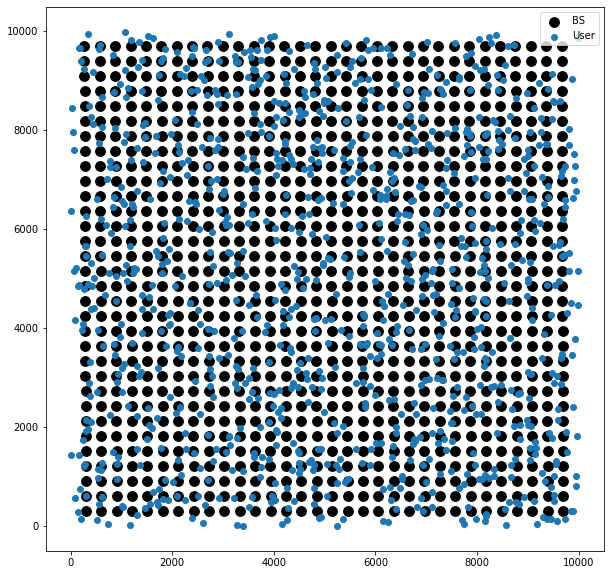

In [0]:
N,R,C,P,connections = Create_simulations(N = 1024,P = 1000, constant= 10000, threshold=100)
x2, value2, avg_value = CSAP(R, connections, C, P, N, iterations=5000)
x1, value1 = Greedy(R, connections, C, P, N, iterations=5000) 
x, value = SAP(R, connections, C, P, N, iterations=5000)

In [0]:
#RATHOD
# value_matrix1 = greedy_value
# value_matrix2 = SAP_value
import matplotlib.pyplot as plt
iterations = 5000
inp_x = np.zeros(iterations-1)
for i in range(0,iterations-1):
  inp_x[i]=i+1
iterations = 5000
inp_x2 = np.zeros(iterations-1)
for i in range(0,iterations-1):
  inp_x2[i]=i+1
p0 = plt.plot(inp_x, value2, label = 'CSAP')
p1 = plt.plot(inp_x2, value1, label = 'Greedy')
p2 = plt.plot(inp_x2, value, label = 'SAP')
plt.legend()